In [13]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import distance_metric, type_metric
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns
dataf = pd.read_csv('../DATASET/Hasil_Gabungan.csv')



featuress = [
    'Residential_2021', 'Industrial_2021', 'Business_2021', 'Social_2021', 'Gov_Office_2021', 
    'Pub_Street_2021', 'Total_2021', 'Residential_2022', 'Industrial_2022', 'Business_2022', 
    'Social_2022', 'Gov_Office_2022', 'Pub_Street_2022', 'Total_2022', 'Residential', 
    'Industrial', 'Business', 'Social', 'Gov_Office', 'Pub_Street', 'Total', 
    'JP_2021', 'JP_2022', 'JP_2023', 'KP_2021', 'KP_2022', 'KP_2023'
]


np.random.seed(42)
dataS = dataf[featuress]
dataS['Provinsi'] = dataf['Province']

scaler = RobustScaler()
dataS_scaled = scaler.fit_transform(dataS[featuress])

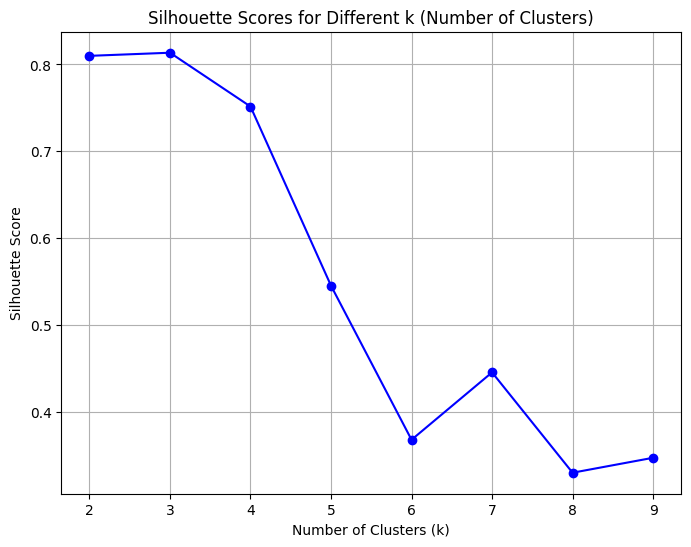

k=2, Silhouette Score=0.8098681704159247
k=3, Silhouette Score=0.8134610115525492
k=4, Silhouette Score=0.751526329088578
k=5, Silhouette Score=0.5453282018956538
k=6, Silhouette Score=0.368047867417848
k=7, Silhouette Score=0.44560989799303463
k=8, Silhouette Score=0.3301349943083913
k=9, Silhouette Score=0.34733079617995244


In [14]:
k_range = range(2, 10)  
sil_scores = []

for k in k_range:
    np.random.seed(42)
    initial_medoids = np.random.choice(range(scaled_features.shape[0]), size=k, replace=False).tolist()

    kmedoids_model = kmedoids(scaled_features, initial_medoids, metric=distance_metric(type_metric.EUCLIDEAN))
    kmedoids_model.process()

    clusters = kmedoids_model.get_clusters()
    labels = np.zeros(len(scaled_features))

    for cluster_idx, cluster in enumerate(clusters):
        labels[cluster] = cluster_idx

    sil_score = silhouette_score(scaled_features, labels)
    sil_scores.append(sil_score)

plt.figure(figsize=(8, 6))
plt.plot(k_range, sil_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Scores for Different k (Number of Clusters)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.xticks(k_range) 
plt.show()

for k, sil_score in zip(k_range, sil_scores):
    print(f"k={k}, Silhouette Score={sil_score}")


In [9]:
data_= dataf[featuress]
scaler = RobustScaler()
scaled_features = scaler.fit_transform(data_)

np.random.seed(42)
initial_medoids = np.random.choice(range(scaled_features.shape[0]), size=4, replace=False).tolist()  

kmedoids_model = kmedoids(scaled_features, initial_medoids, metric=distance_metric(type_metric.EUCLIDEAN))
kmedoids_model.process()

clusters = kmedoids_model.get_clusters()
centers = kmedoids_model.get_medoids()


cluster_provinces = {}
provinces = dataf['Province'].tolist() 

for cluster_idx, cluster in enumerate(clusters):
    cluster_provinces[cluster_idx] = [provinces[i] for i in cluster]

for cluster_idx, provinces_in_cluster in cluster_provinces.items():
    print(f"Cluster {cluster_idx + 1}: {', '.join(provinces_in_cluster)}")

labels = np.zeros(len(scaled_features))  
for cluster_idx, cluster in enumerate(clusters):
    labels[cluster] = cluster_idx  

sil_score = silhouette_score(scaled_features, labels)
print(f"Silhouette Score: {sil_score}")


Cluster 1: Aceh, Sumatera Utara, Sumatera Barat, Riau, Kep. Riau, Sumatera Selatan, Jambi, Bengkulu, Kep. Bangka Belitung, Lampung, Kalimantan Barat, Kalimantan Selatan, Kalimantan Tengah, Sulawesi Utara, Gorontalo, Sulawesi Tengah, Sulawesi Selatan, Sulawesi Tenggara, Sulawesi Barat, Maluku, Maluku Utara, Papua, Papua Barat, Bali, Nusa Tenggara Barat, Nusa Tenggara Timur, DI Yogyakarta, Kalimantan Timur, Kalimantan Utara
Cluster 2: DKI Jakarta
Cluster 3: Banten
Cluster 4: Jawa Timur, Jawa Tengah, Jawa Barat
Silhouette Score: 0.751526329088578


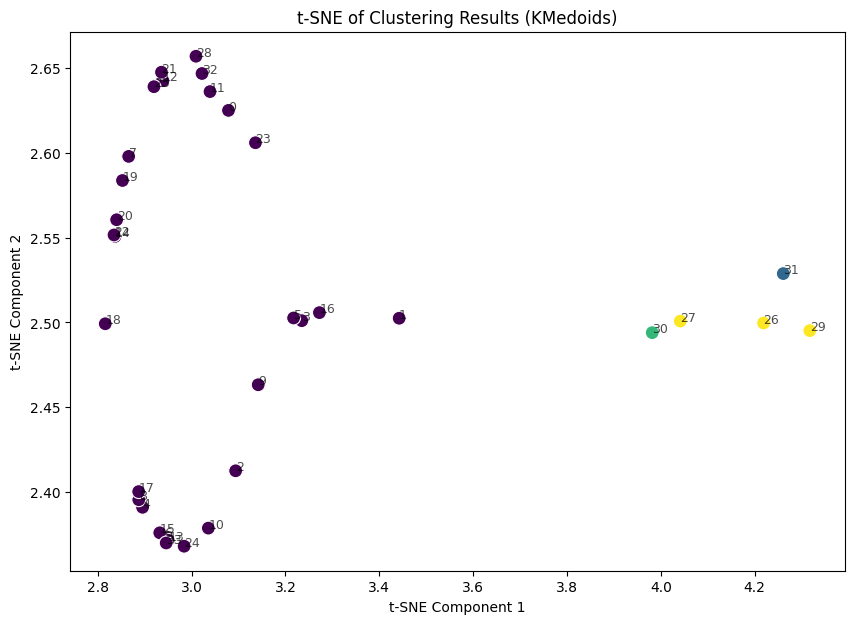

In [5]:
def plot_tsne_with_clusters(X, clusters, provinsi_names):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)  

    df_tsne = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])

    cluster_labels = np.zeros(len(X))  
    for cluster_idx, cluster in enumerate(clusters):
        cluster_labels[cluster] = cluster_idx  

    df_tsne['Cluster'] = cluster_labels
    df_tsne['Provinsi'] = provinsi_names

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_tsne, x='tSNE1', y='tSNE2', hue='Cluster', palette='viridis', s=100, legend=None)

    for i in range(len(provinsi_names)):
        plt.text(df_tsne.loc[i, 'tSNE1'], df_tsne.loc[i, 'tSNE2'], str(i), fontsize=9, alpha=0.7)
    
    plt.title('t-SNE of Clustering Results (KMedoids)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

plot_tsne_with_clusters(scaled_features, clusters, dataf['Province'].tolist())